<a href="https://colab.research.google.com/github/Srinadh-Vempati/Neural_Style_Transfer/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as kr
import numpy as np
from IPython import display
from PIL import Image
tf.executing_eagerly()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [ ]:
content = '/content/drive/MyDrive/pic.jpg'
style = '/content/drive/MyDrive/da-vinci-drawings.jpg'

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400

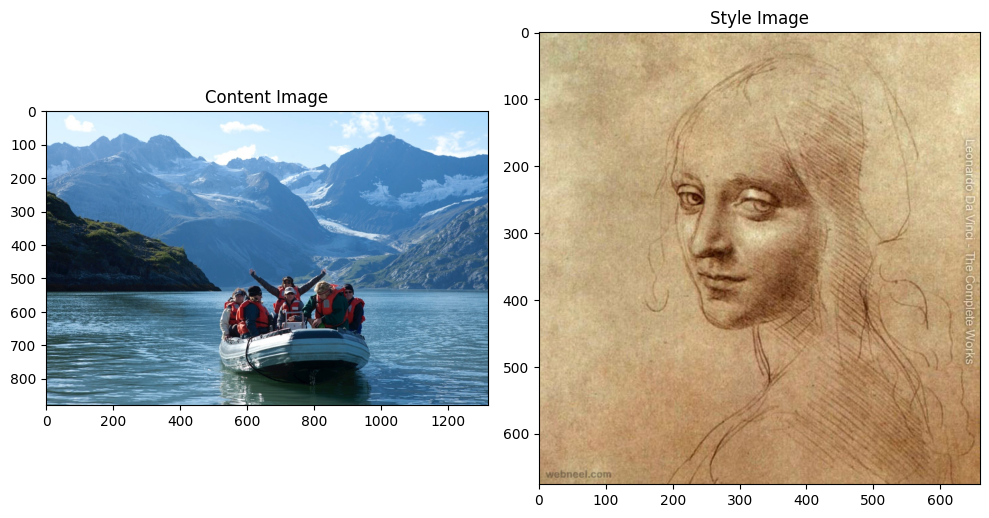

In [ ]:
content = Image.open(content)
style = Image.open(style)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.tight_layout()
plt.show()

In [ ]:
def img_parser(filename):
    # img_string = tf.io.read_file(filename)
    # img = tf.image.decode_jpeg(img_string, channels=3)
    img = filename
    img = tf.cast(img, dtype=tf.float32)

    # Resize the image
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.expand_dims(img, axis=0)   # Add batch dimension
    return img

In [ ]:
def load_image(filename):
    img = img_parser(filename)
    img = kr.applications.vgg19.preprocess_input(img)
    return img

In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
_vgg = kr.applications.vgg19.VGG19(include_top=False,
                                   weights=None,
                                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 300, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 100, 128)      0     

In [ ]:
content_layers = ['block5_conv2']

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
def get_model(styles, contents):
    """ Creates our model with access to intermediate layers.
    Loads the VGG19 model and access the intermediate layers.
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model.

    Parameters:
    -----------
    styles: list
        A list containing all style layers from VGG19 model
    contents: list
        A list containing all content layers from VGG19 model

    Returns:
    --------
    VGG: kr.Model
        A keras model that takes image inputs and outputs the style and
        content intermediate layers.
    """

    vgg = kr.applications.vgg19.VGG19(include_top=False,
                                      weights='imagenet',
                                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg.trainable = False

    # Get output layers corresponding to style and content layers
    style_outputs = [vgg.get_layer(layer_name).output for layer_name in styles]
    content_outputs = [vgg.get_layer(layer_name).output for layer_name in contents]
    model_outputs = style_outputs + content_outputs

    return kr.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

In [ ]:
def get_layer_style_loss(style, generated):
    def gram_matrix(tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(tf.shape(a)[0], tf.float32)

    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))


def get_style_loss(style, generated):
    loss = 0
    coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]
    for s, g, coeff in zip(style, generated, coeffs):
        loss += coeff * get_layer_style_loss(s, g)

    return loss

In [ ]:
def compute_loss(model, image, style_features, content_features, alpha=0.1, beta=0.002):
    """This function will compute the loss total loss.

    Parameters:
    -----------
    model: kr.Model
        The model that will give us access to the intermediate layers
    image: Tensor
        Initial image. This is what we are updating with the optimization process.
    style_features: Tensor
        Precomputed style features from our Style image.
    content_features: Tensor
        Precomputed content features from our Content image.

    Returns:
    loss: Tensor
        Returns the total loss
    """

    # Feed our init image through our model.
    model_outputs = model(image)

    content_generated = [content_layer[0] for content_layer in model_outputs[len(style_layers):]][0]
    style_generated = [style_layer for style_layer in model_outputs[:len(style_layers)]]

    content_loss = alpha * get_content_loss(content_features, content_generated)
    style_loss = beta * get_style_loss(style_features, style_generated)

    # Get total loss
    loss = style_loss + content_loss
    return loss

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    # Compute gradients with respect to input image
    return tape.gradient(loss, cfg['image']), loss

In [104]:
def transfer_style(content_img, style_img, epochs=1000):
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""

        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False

    S = load_image(style_img)
    C = load_image(content_img)

    style_outputs = model(S)
    content_outputs = model(C)

    # Get the style and content feature representations (from our specified intermediate layers)
    _content = [content_layer[0] for content_layer in content_outputs[len(style_layers):]][0]
    _style = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]

    # Set initial image
    G = generate_noisy_image(C, 0.6)
    G = tf.Variable(G, dtype=tf.float32)

    best_loss, best_img = float('inf'), None

    # Create a nice config
    cfg = {
        'model': model,
        'image': G,
        'style_features': _style,
        'content_features': _content
    }

    # Create our optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=1)

    # For displaying
    display_interval = epochs/(2*5)

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grads, cost = compute_grads(cfg)
        opt.apply_gradients([(grads, G)])
        clipped = tf.clip_by_value(G, min_vals, max_vals)
        G.assign(clipped)

        if cost < best_loss:
            best_loss = cost
            best_img = deprocess_img(G.numpy())

        if i % display_interval== 0:
            plot_img = G.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            display.clear_output(wait=True)
            display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}, LOSS: {:.4e}'.format(i, cost))


    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

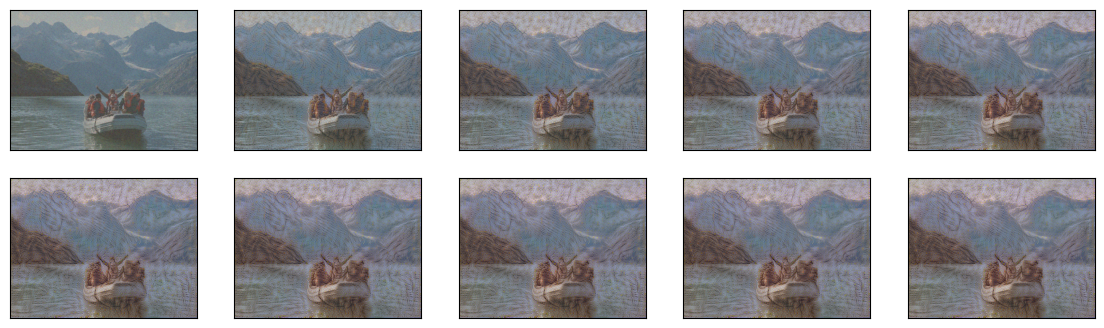

In [105]:
best, best_loss = transfer_style(content, style, epochs=200)